In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tld import get_tld
import re
from nltk.corpus import words
import nltk
import textdistance as td
import scipy as sp
import seaborn as sns
from Levenshtein import distance
nltk.download('words')
import json

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sorof\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
def get_tld_custom(dom):
    # Extract top-level domain
    try:
        tld = get_tld(dom, fix_protocol=True)
        return tld
    except:
        tld = dom.split(".")[-1]
        return tld


In [3]:
df = pd.read_csv("./ARTISAN2023_challenge/dga_domains_sample.csv", names=["label_binary", "label_family", "domain"])

In [4]:
df.head()

,label_binary,label_family,domain
0,dga,gozi,mortiscontrastatim.com
1,dga,corebot,cvyh1po636avyrsxebwbkn7.ddns.net
2,legit,alexa,plasticbags.sa.com
3,legit,alexa,mzltrack.com
4,legit,alexa,miss-slim.ru


### 1. Basic characterization ~ 30 mins

1.1) What is the size of the dataset?

In [5]:
df.shape[0]

10000

1.2) How many families are there in the dataset?

In [6]:
df["label_family"].unique()

array(['gozi', 'corebot', 'alexa', 'ranbyus', 'symmi', 'emotet',
       'dircrypt', 'matsnu', 'simda', 'fobber', 'pushdo', 'qadars',
       'kraken', 'ramnit', 'nymaim', 'pykspa', 'tinba', 'murofet',
       'cryptolocker', 'ramdo', 'vawtrak', 'conficker', 'padcrypt',
       'rovnix', 'suppobox', 'necurs'], dtype=object)

1.3) How many samples are there for each binary label?

In [7]:
df["label_binary"].value_counts()

legit    5019
dga      4981
Name: label_binary, dtype: int64

1.4) How many samples are there for each family label? Plot a bar chart.

<AxesSubplot:>

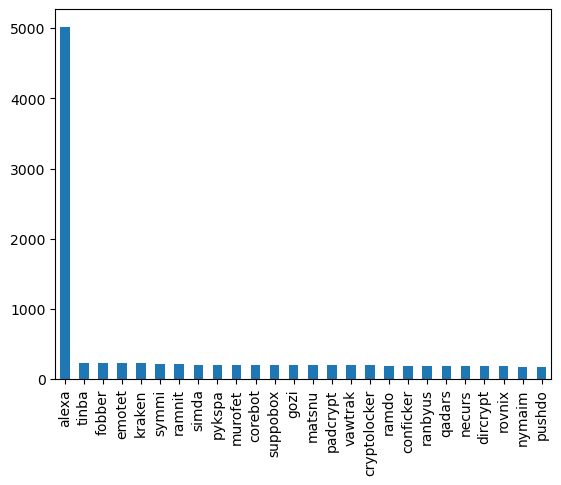

In [8]:
df.label_family.value_counts().plot.bar()

1.5) How many different Top Level Domains (.eu, .it, .fr, etc.) are there for each family? Plot a bar chart

In [9]:
df["tld"] = df["domain"].apply(get_tld_custom)

In [10]:
check_tld = df.groupby("label_family").agg({"tld":[pd.Series.unique, pd.Series.nunique]})
check_tld.head()

tld        
                                                         unique nunique
label_family                                                           
alexa         [sa.com, com, ru, jp, com.pe, com.br, org, de,...     305
conficker     [nl, com.mt, hn, com.bo, com.ve, ps, com.pe, c...      99
corebot                                              [ddns.net]       1
cryptolocker              [biz, org, ru, com, co.uk, info, net]       7
dircrypt                                                  [com]       1

In [11]:
check_tld.columns = ["tlds", "n_tlds"]

In [12]:
check_tld = check_tld.sort_values(by="n_tlds", ascending =False)

<AxesSubplot:xlabel='label_family'>

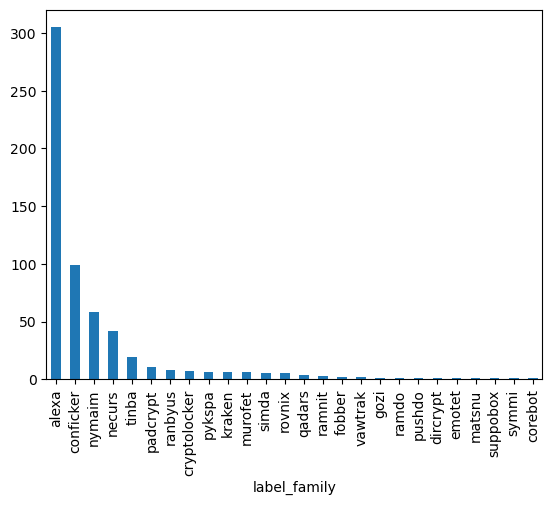

In [13]:
check_tld["n_tlds"].plot.bar()

1.6) Plot the domain length distribution among different families. Hint: use Dataframe.boxplot().
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html


In [14]:
df["domain_length"] = df["domain"].apply(lambda x: len(x))

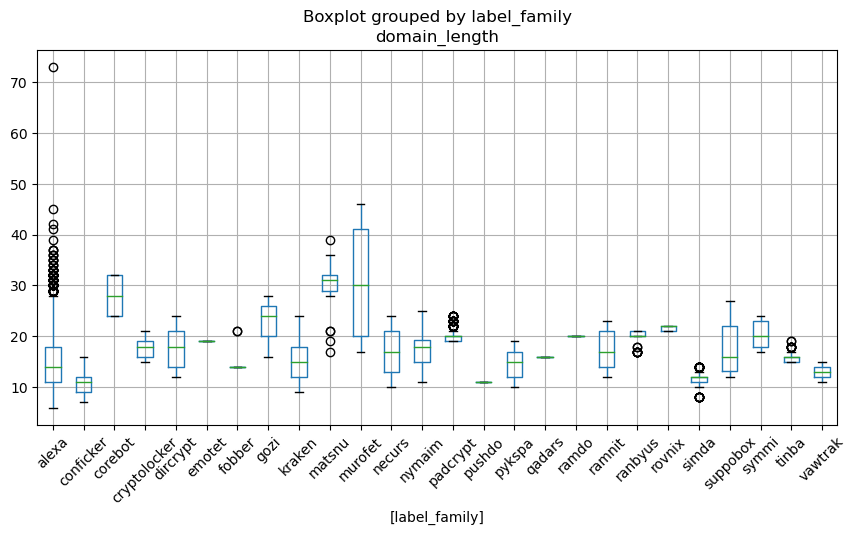

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
df.boxplot(by="label_family", ax=ax)
plt.xticks(rotation=45)
plt.show()

1.7) Choose a single SMALL family, plot a matrix showing the Leveshtein edit distance (https://en.wikipedia.org/wiki/Levenshtein_distance) between each pair of domains.

In [16]:
label_family = "pykspa"
domain_list = df[df["label_family"] == label_family].domain.values
domain_list = domain_list.reshape(domain_list.shape[0],1)
domain_list

array([['guzcwufqbex.org'],
       ['tqdwjcn.com'],
       ['gbxqsufqbex.com'],
       ['lbhqdifox.org'],
       ['gaxkpo.biz'],
       ['wgdbgo.biz'],
       ['qbhawadsholapet.com'],
       ['cwaeqyeoya.net'],
       ['gcvmik.info'],
       ['rupcesn.cc'],
       ['cznerufqbex.cc'],
       ['atnozgfqbex.cc'],
       ['kjtagufqbex.org'],
       ['guefgwiugkeq.net'],
       ['tryadsfox.cc'],
       ['ikjwladsholapet.cc'],
       ['pvgemifox.com'],
       ['uskuka.biz'],
       ['uszovk.net'],
       ['eeqpjkdsholapet.org'],
       ['ekcspeiq.net'],
       ['xajqygn.org'],
       ['klhzoanansnan.com'],
       ['kufxbgfqbex.org'],
       ['gpejvsdsholapet.org'],
       ['qecgaodsholapet.org'],
       ['oxluxenansnan.com'],
       ['ccpodo.biz'],
       ['equvkueoya.info'],
       ['wjoipwnansnan.org'],
       ['fpzgzgn.com'],
       ['yurqmueoya.info'],
       ['cgsowiiugkeq.biz'],
       ['qgtmkgfqbex.org'],
       ['ixptusdsholapet.com'],
       ['wesifanansnan.com'],
       ['aykeomiq.

In [17]:
%time
lev_ex_distance = sp.spatial.distance.pdist(domain_list, lambda x,y: getattr(td, 'levenshtein').distance(x[0],y[0]))
lev_ex_distance =  sp.spatial.distance.squareform(lev_ex_distance, force='no', checks=True)


Wall time: 0 ns


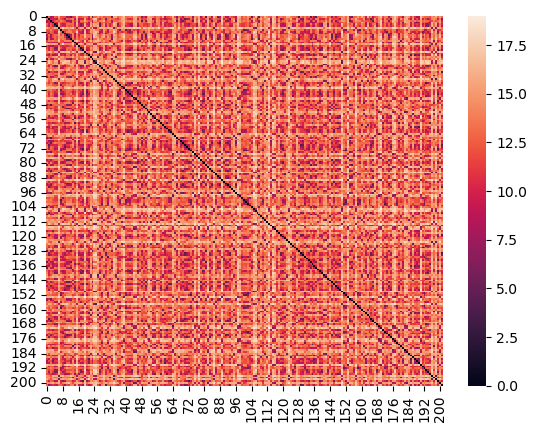

In [18]:
plt.figure()
sns.heatmap(lev_ex_distance)
#plt.title(dist)
plt.show()

### 2. Feature generation

Example feature: n-gram prononuceability

In [19]:
def generate_ngram(x, n=2):
    # Extract n-grams for a given n
    no_tld = x.split(".")[0] # remove tld
    ngram_list = []
    
    try:
        for i in range(len(no_tld)-n):
            ngram_list.append(no_tld[i:i+n])

        ngram_list.append(no_tld[i+1:])

        return ngram_list
    except:
        return [no_tld]

    
word_dict = words.words()
def check_dictionary(x, dictionary = word_dict):
    # check if the n-gram exists in english dictionary
    
    occurrences = len(set(x) & set(dictionary))
    return occurrences/len(x)

In [20]:
def num_ratio(x):
    # calculate how many numerical characters are present in each domain
    res = re.findall(r'\d+', x)
    
    if len(res) != 0:
        return len(res)/len(x)
    else:
        return 0
    

In [21]:
def char_ratio(x):
    # calculate how many special characters are present in each domain
    res = re.findall('[|^&+\-%*/=!>_]', x)
    
    if len(res) != 0:
        return len(res)/len(x)
    else:
        return 0

In [22]:
def vowel_ratio(x):
    # calculate how many vowels are present in each domain
    return sum(map(x.lower().count, "aeiou"))/len(x)

In [23]:
df["num_ratio"] = df["domain"].apply(num_ratio) 
df["char_ratio"] =  df["domain"].apply(char_ratio)
df["vowel_ratio"] =  df["domain"].apply(vowel_ratio)

In [24]:
# This operation needs time and computational resources, debug with smaller sample!

df["2-gram"] =  df["domain"].apply(generate_ngram)
df["3-gram"] =  df["domain"].apply(generate_ngram,n=3)
#df["4-gram"] =  df["domain"].apply(generate_ngram,n=4)
#df["5-gram"] =  df["domain"].apply(generate_ngram,n=5)
#df["6-gram"] =  df["domain"].apply(generate_ngram,n=6)

df["2-gram_ratio"] =  df["2-gram"].apply(check_dictionary)
df["3-gram_ratio"] =  df["3-gram"].apply(check_dictionary)
#df["4-gram_ratio"] =  df["4-gram"].apply(check_dictionary)
#df["5-gram_ratio"] =  df["5-gram"].apply(check_dictionary)
#df["6-gram_ratio"] =  df["6-gram"].apply(check_dictionary)

df = df.drop(["3-gram", "2-gram"], axis=1)
#df = df.drop(["4-gram", "5-gram", "6-gram"], axis=1)

In [26]:
df

,label_binary,label_family,domain,tld,domain_length,num_ratio,char_ratio,vowel_ratio,2-gram_ratio,3-gram_ratio
0,dga,gozi,mortiscontrastatim.com,com,22,0.000000,0.000000,0.318182,0.588235,0.437500
1,dga,corebot,cvyh1po636avyrsxebwbkn7.ddns.net,ddns.net,32,0.093750,0.000000,0.125000,0.090909,0.000000
2,legit,alexa,plasticbags.sa.com,sa.com,18,0.000000,0.000000,0.277778,0.500000,0.444444
3,legit,alexa,mzltrack.com,com,12,0.000000,0.000000,0.166667,0.142857,0.166667
4,legit,alexa,miss-slim.ru,ru,12,0.000000,0.083333,0.250000,0.375000,0.142857
...,...,...,...,...,...,...,...,...,...,...
9995,dga,murofet,k37f12b28pza37kvfth54gydvgqayoujxdreu.biz,biz,41,0.121951,0.000000,0.170732,0.166667,0.028571
9996,dga,padcrypt,bkfoebdlccafmfbe.org,org,20,0.000000,0.000000,0.250000,0.200000,0.071429
9997,dga,fobber,mdoqihhgij.com,com,14,0.000000,0.000000,0.285714,0.111111,0.000000
9998,legit,alexa,portinhola.com.br,com.br,17,0.000000,0.000000,0.294118,0.666667,0.250000


### 3. Classification

Select a classifier from https://scikit-learn.org/stable/search.html?q=classifier and run a full classification pipeline.

Warnings: 
- According to the model you choose you might need/not need to scale your data (https://scikit-learn.org/stable/search.html?q=scaler)
- Don't forget to encode the categorical features: : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
- Perform cross-validation to avoid overfitting and find the best set of parameters:
    - https://scikit-learn.org/stable/modules/cross_validation.html 
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=grid%20search#sklearn.model_selection.GridSearchCV
- Evaluate the classification metrics: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification%20report#sklearn.metrics.classification_report


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [31]:
df_train_binary = pd.read_csv("./features_train_family.csv")
df_test_binary = pd.read_csv("./features_test_family.csv") 

In [32]:
df_train_binary

,domain,domain_length,family,tld,num_ratio,3-gram_check,4-gram_check,5-gram_check,6-gram_check,char_check,dist_mean,dist_median,dist_std,dist_max
0,jlppuvkglsxfrpgxiyhhhhuwdfdgsdupikizkriq.pro,44,makloader,pro,0.000000,2,1,0,0,0.0,38.881655,39.0,1.710235,57.0
1,bncfkeffcclbkbcm.net,20,padcrypt,net,0.000000,1,0,0,0,0.0,19.362369,18.0,5.307785,57.0
2,theprogramswiththatt.com,24,gozi,com,0.000000,9,5,1,0,0.0,21.542087,21.0,4.872087,58.0
3,uo6oteyio5e61mjb87.biz,22,rovnix,biz,0.181818,0,0,0,0,0.0,21.163274,20.0,4.586924,58.0
4,yzsnqir.biz,11,conficker,biz,0.000000,0,0,0,0,0.0,16.881981,15.0,7.631332,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32876,pdrfrmmpgqjlxrjm.net,20,murofet,net,0.000000,0,0,0,0,0.0,19.546896,18.0,5.700851,57.0
32877,crldtf4y21pn5iqa.org,20,chinad,org,0.150000,0,0,0,0,0.0,19.651446,18.0,5.102534,58.0
32878,amhrijphupumcriu.eu,19,emotet,eu,0.000000,2,0,0,0,0.0,19.359965,17.0,5.785025,58.0
32879,vihocit.info,12,simda,info,0.000000,1,0,0,0,0.0,16.649510,15.0,7.470719,55.0


In [33]:
df_train_binary = df_train_binary[[i for i in df_train_binary.columns if i != "domain"]]
df_test_binary = df_test_binary[[i for i in df_test_binary.columns if i != "domain"]]

In [34]:
X_train = df_train_binary[[col for col in df_train_binary.columns if col != "family"]]
X_test = df_test_binary[[col for col in df_test_binary.columns if col != "family"]]

y_train = df_train_binary["family"]
y_test = df_test_binary["family"]

In [35]:
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(X_train["tld"].values.reshape(-1,1))

tld_econded_train = pd.DataFrame(enc.transform(X_train["tld"].values.reshape(-1,1)).toarray())
tld_econded_test = pd.DataFrame(enc.transform(X_test["tld"].values.reshape(-1,1)).toarray())

X_train = X_train.reset_index().merge(tld_econded_train,right_index=True, left_index=True )
X_train = X_train.drop(["tld"],axis=1)

X_test = X_test.reset_index().merge(tld_econded_test,right_index=True, left_index=True )
X_test = X_test.drop(["tld"],axis=1)



In [36]:
param_grid = {
    "max_depth" : [10, 15, 20],
    "n_estimators" : [50, 100]
}

In [37]:
rf = RandomForestClassifier()

In [38]:
grid_search = GridSearchCV(estimator=rf, cv=10, param_grid=param_grid)

In [39]:
rf_model = grid_search.fit(X_train, y_train)

c:\Users\sorof\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\sorof\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\sorof\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\sorof\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\sorof\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858:

In [40]:
rf_model.best_estimator_.max_depth

20

In [41]:
rf_model.cv_results_

{'mean_fit_time': array([1.59308748, 4.19667668, 3.14109576, 7.01649063, 4.44079242,
        9.40226541]),
 'std_fit_time': array([0.05038728, 0.41260537, 0.06943411, 0.58946372, 0.35366057,
        0.99437074]),
 'mean_score_time': array([0.06510749, 0.15747249, 0.09602537, 0.1873594 , 0.1091265 ,
        0.22136526]),
 'std_score_time': array([0.00328031, 0.01298005, 0.01125062, 0.02025031, 0.00974677,
        0.04463312]),
 'param_max_depth': masked_array(data=[10, 10, 15, 15, 20, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100, 50, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100},
  {'max_depth': 15, 'n_estimators': 50},
  {'max_depth': 15, 'n_estimators': 100},
  {'max_depth': 20, 'n_estimat

In [56]:
y_pred = rf_model.predict(X_test)

# save classification report and metrics
class_report = classification_report(y_test, y_pred, output_dict = True)

C:\Users\sorof\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sorof\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sorof\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
pd.DataFrame(class_report)

,bamital,banjori,bedep,beebone,benign,blackhole,bobax,ccleaner,chinad,conficker,...,vidro,vidrotid,virut,volatilecedar,wd,xshellghost,xxhex,accuracy,macro avg,weighted avg
precision,0.996960,0.796196,0.438144,0.967742,0.721893,0.250000,0.583333,0.0,0.979710,0.408784,...,0.453704,0.200000,0.862170,0.969512,1.0,0.0,0.971264,0.723327,0.670930,0.728352
recall,1.000000,0.890578,0.572391,0.606061,0.362018,0.076923,0.134615,0.0,0.991202,0.374613,...,0.340278,0.020408,1.000000,1.000000,1.0,0.0,0.997050,0.723327,0.640379,0.723327
f1-score,0.998478,0.840746,0.496350,0.745342,0.482213,0.117647,0.218750,0.0,0.985423,0.390953,...,0.388889,0.037037,0.925984,0.984520,1.0,0.0,0.983988,0.723327,0.642150,0.712682
support,328.000000,329.000000,297.000000,99.000000,337.000000,13.000000,104.000000,1.0,341.000000,323.000000,...,288.000000,98.000000,294.000000,159.000000,335.0,1.0,339.000000,0.723327,16196.000000,16196.000000


In [58]:
with open('class_report_family.json', 'w') as outfile:
    json.dump(class_report, outfile)